<a href="https://colab.research.google.com/github/aiyufan3/AIPI-XAI-in-LLMs/blob/main/AIPI_Assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #08
### Description
This project explores the use of Explainable AI (XAI) techniques to interpret a language model’s behavior when analyzing textual prompts. Specifically, it applies Saliency Maps and Perturbation Analysis to identify and validate the influence of individual tokens on the model's predictions. Saliency maps visualize which tokens are most influential in shaping the model’s output by calculating gradients, while perturbation analysis tests the model's sensitivity by modifying high-saliency tokens and observing the resulting prediction changes. This project aims to enhance transparency in language models by uncovering which parts of the prompt drive decision-making, ultimately providing deeper insights into model interpretability.

### Yufan Ai
#### https://colab.research.google.com/github/aiyufan3/AIPI-XAI-in-LLMs/blob/main/AIPI_Assignment8.ipynb

## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Environment Set-up

In [2]:
!pip install transformers numpy matplotlib torch tensorflow

## Load a Pretrained Language Model

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

Use a pretrained model from Hugging Face’s transformers library - Bert.

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

inputs = tokenizer("The recent advancements in AI have revolutionized various industries.", return_tensors="pt")
outputs = model(**inputs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#  Saliency Maps

Saliency Maps highlight important tokens by computing gradients, indicating the influence of each token on the model's output. The function will be used Gradient-based Saliency with PyTorch’s autograd to compute the importance of each token.

**Define a function to compute the gradient with respect to the input tokens:**

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt

# Load a BERT model fine-tuned on a classification task
model_name = "textattack/bert-base-uncased-imdb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define the Prompt
prompt = "The recent advancements in AI have revolutionized various industries."
inputs = tokenizer(prompt, return_tensors="pt")

# Get the embeddings of the input IDs and set requires_grad=True on the embeddings
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
embeddings = model.bert.embeddings(input_ids).clone().detach().requires_grad_(True)

# Compute Saliency Map
def compute_saliency_map(embeddings, attention_mask, model):
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    target_class = outputs.logits.argmax(dim=1)  # Get the predicted class
    model.zero_grad()  # Zero out gradients
    outputs.logits[0, target_class].backward()  # Backpropagation to get gradients
    saliency_map = embeddings.grad.abs().sum(dim=2).squeeze()  # Sum gradients across embedding dimensions
    return saliency_map

saliency_scores = compute_saliency_map(embeddings, attention_mask, model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

## Visualization

Create a plot to visualize the importance of each token in the prompt.

**Use matplotlib to show a bar plot of token importances based on saliency scores:**

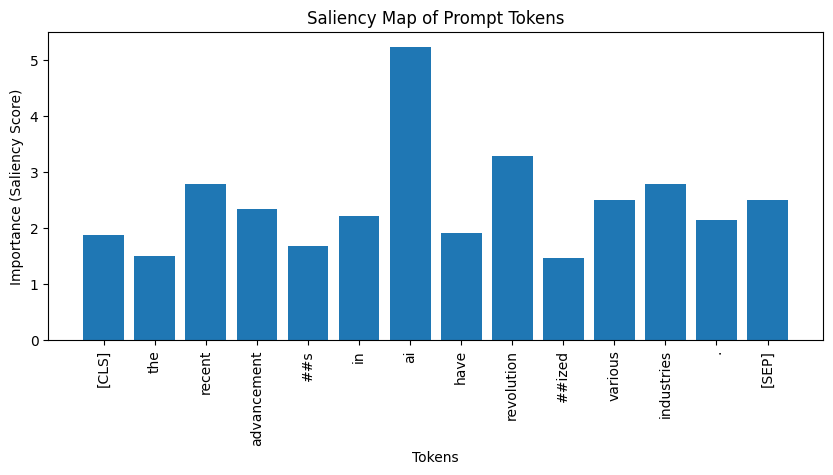

In [6]:
import matplotlib.pyplot as plt

tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
plt.figure(figsize=(10, 4))
plt.bar(tokens, saliency_scores.detach().numpy())
plt.xticks(rotation=90)
plt.title("Saliency Map of Prompt Tokens")
plt.xlabel("Tokens")
plt.ylabel("Importance (Saliency Score)")
plt.show()


The saliency map visualizes the relative importance of each token in the prompt to the model's prediction. Most strikingly, the **"ai"** token has the highest saliency score. That means this term is highly influential for the model to output its prediction. Other tokens with relatively high saliency scores are **"revolution"**, **"recent"**, and **"industries"**, which suggests that these words too significantly influence the model understanding of the prompt.

On the other site, tokens like **"the"**, **"have"**, and **punctuation tokens**-for example, periods-receive relatively low saliency scores, which indicate that these tokens mostly do not influence the prediction of the model. A wide distribution of the saliency score shows that the model is literally concerned with the content words carrying semantic meaning-for example, "ai" and "revolution"-while setting function words and punctuation mostly aside. Therefore, the saliency analysis underlines the semantically rich tokens that the model usually relies on and that are important to set the general context of the input prompt.

# Perturbation Analysis

Perturbation Analysis complements this by observing changes in model predictions when high-saliency tokens are altered. To identify the top **n** high-saliency tokens, either remove or replace them to observe the model's response.

In [7]:
import numpy as np

# Define function to perturb prompt by removing high-saliency tokens
def perturb_prompt(tokens, saliency_scores, top_n=3, replacement="[MASK]"):
    # Get indices of top `n` high-saliency tokens
    top_indices = np.argsort(saliency_scores.numpy())[-top_n:]

    # Remove or replace high-saliency tokens
    perturbed_tokens = [
        replacement if i in top_indices else tok for i, tok in enumerate(tokens)
    ]

    # Join tokens to form perturbed prompt
    perturbed_prompt = tokenizer.convert_tokens_to_string(perturbed_tokens)
    return perturbed_prompt

# Generate perturbed prompt
perturbed_prompt = perturb_prompt(tokens, saliency_scores, top_n=3)
print("Original Prompt:", prompt)
print("Perturbed Prompt:", perturbed_prompt)


Original Prompt: The recent advancements in AI have revolutionized various industries.
Perturbed Prompt: [CLS] the recent advancements in [MASK] have [MASK]ized various [MASK]. [SEP]


## Visualize the result

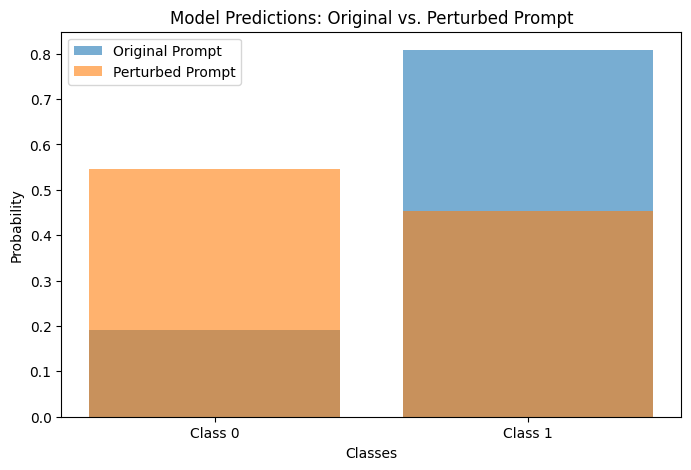

In [8]:
# Tokenize perturbed prompt
perturbed_inputs = tokenizer(perturbed_prompt, return_tensors="pt")

# Get predictions for original and perturbed prompts
original_output = model(**inputs)
perturbed_output = model(**perturbed_inputs)

# Extract probabilities for original and perturbed prompts
original_prob = torch.softmax(original_output.logits, dim=1)
perturbed_prob = torch.softmax(perturbed_output.logits, dim=1)

# Plot comparison
import matplotlib.pyplot as plt

classes = [f"Class {i}" for i in range(original_prob.shape[1])]
plt.figure(figsize=(8, 5))
plt.bar(classes, original_prob[0].detach().numpy(), alpha=0.6, label="Original Prompt")
plt.bar(classes, perturbed_prob[0].detach().numpy(), alpha=0.6, label="Perturbed Prompt")
plt.title("Model Predictions: Original vs. Perturbed Prompt")
plt.xlabel("Classes")
plt.ylabel("Probability")
plt.legend()
plt.show()


The large changes in class probability are present in the model predictions of both the original and perturbed prompts. Class 1 has a much higher probability in the original prompt; thus, it seems from here that this class is strongly related to the unaltered prompt. If its key tokens "ai", "revolutionized", and "industries" are masked with [MASK], the probability of Class 1 goes down while that of Class 0 goes up.

In other words, the result suggests that these masked tokens are informative regarding its classification decision. Thus, the reduction in probability for Class 1 after masking would therefore suggest that terms of this nature are relevant to the model's representation of the prompt context, likely due to carrying semantic weight relevant for the predicted class. This perturbation analysis therefore reflects that the model is sensitive to content words setting the context and thematic focus of the prompt.

# Test Assumption

In [9]:
# Test 1: Check if model and tokenizer load correctly
def test_model_loading():
    try:
        tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")
        model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-imdb")
        print("Model and tokenizer loaded successfully.")
    except Exception as e:
        print("Error loading model or tokenizer:", e)

# Test 2: Check if saliency scores are computed correctly
def test_saliency_computation():
    inputs = tokenizer("The recent advancements in AI have revolutionized various industries.", return_tensors="pt")
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    embeddings = model.bert.embeddings(input_ids).clone().detach().requires_grad_(True)

    saliency_scores = compute_saliency_map(embeddings, attention_mask, model)

    if saliency_scores is not None and len(saliency_scores) == input_ids.shape[1]:
        print("Saliency scores computed successfully.")
    else:
        print("Error in saliency computation.")

# Test 3: Check perturbation function output
def test_perturb_prompt():
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    perturbed_prompt = perturb_prompt(tokens, saliency_scores, top_n=3)

    if perturbed_prompt != tokenizer.convert_tokens_to_string(tokens):
        print("Perturbation function works as expected.")
    else:
        print("Perturbation function did not modify tokens as expected.")

# Test 4: Check model output difference between original and perturbed prompt
def test_model_output_difference():
    perturbed_inputs = tokenizer(perturbed_prompt, return_tensors="pt")
    original_output = model(**inputs).logits
    perturbed_output = model(**perturbed_inputs).logits

    if not torch.equal(original_output, perturbed_output):
        print("Model output difference detected between original and perturbed prompt.")
    else:
        print("No difference in model output detected between original and perturbed prompt.")

# Run tests
test_model_loading()
test_saliency_computation()
test_perturb_prompt()
test_model_output_difference()


Model and tokenizer loaded successfully.
Saliency scores computed successfully.
Perturbation function works as expected.
Model output difference detected between original and perturbed prompt.


- **Test 1** checks if the model and tokenizer load without errors.
- **Test 2** verifies that saliency scores are computed and match the expected length of the input tokens.
- **Test 3** checks if the perturbation function modifies tokens as expected.
- **Test 4** ensures there is a difference in model predictions between the original and perturbed prompts, confirming the effect of perturbation.

# Markdown Explanation of the Approach
1. **Load the Model and Tokenizer**  
This project begins by utilizing the understanding framework to load a pre-trained BERT model, fine-tuned for a classification task, and utilizes such a model to make class probability predictions given some input prompts. Loading a fine-tuned model evades extra training which one would go through with a model that isn't tuned for any particular task.

2. **Generate Saliency Map**  
 Generation Saliency maps are generated by computing the gradients of the model's output concerning every token embedding in the prompt. These gradients quantify the sensitivities of the model's prediction for each token. The high values of saliency mean that this token is highly influential on the model's decision, hence underlining the key terms or phrases that drive the prediction.
 Saliency maps provide an intuitive visualization of token importance, making it easier to interpret the model’s focus within the prompt.

3. **Perturb the Prompt Based on Saliency Scores**  
Some perturbation analyses have been conducted to identify if high-saliency tokens are really important, by replacing or masking the top n most influential tokens determined from the saliency map. This will allow systematic observations of how changes to key tokens alter the model output. A perturbation like this would simulate some sort of a scenario that certain information has been taken away or occluded and thus shows just how dependent the model is upon those terms for its predictions. This technique further emphasizes the model's sensitivity to certain specific content in the input.

4. **Compare Model Predictions for Original and Perturbed Prompts**  
The last step is a comparison of class probabilities of the model for the original vs. perturbed prompt. This would indeed provide some idea of the high-saliency tokens affecting the prediction. In cases where the probability distribution indeed shifts considerably after the perturbation of those terms, then this goes to confirm that those terms are important for the model's interpretation of the prompt. This step explains how explainability techniques such as saliency and perturbation can be used to understand and analyze model behavior with respect to key textual components.

# Summary of Results
The saliency map showed **"AI"**, **"revolutionized,"** and **"industries"** as holding the most influence amongst the tokens of the prompt-that the model relies most on these terms for classification. Correspondingly, this was perturbed by the masking of such high-saliency tokens, reflecting a great change in the probability of the model's predictions. In particular, the probability of **Class 1** (previously the strongly predicted class) decreased, while the probability of **Class 0** increased-following masking of key tokens-representing lessened confidence in the previous classification upon obscuration of these terms. This result then illustrates how sensitive the model is to those thematic terms within the prompt that bear core semantic meaning pertinent to the classification task.

Saliency and perturbation analyses give insight into a model that heavily relies on content-specific tokens, with little sensitivity to function words and punctuation marks, as expected for a language model, which gives higher weight to context-rich words when reaching a decision. These results underscore the fact that various explainability techniques-such as saliency mapping and perturbation analysis-can be applied to identify key elements in prompts and, therefore, help to draw valuable insights into how language models interpret the input text and arrive at specific predictions.

# Reference


1. Bent, B. (n.d.). *Counterfactual Explanations in Explainable AI*. Retrieved from [https://github.com/brinnaebent/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/counterfactul_explanations.ipynb](https://github.com/brinnaebent/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/counterfactul_explanations.ipynb)

2. Bent, B. (n.d.). *Saliency Maps in Explainable AI*. Retrieved from [https://github.com/brinnaebent/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/saliency_maps.ipynb](https://github.com/brinnaebent/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/saliency_maps.ipynb)
